# F20AA Coursework 2


In [1]:
import googleapiclient.discovery
import googleapiclient.errors
import numpy as np
import pandas as pd
import glob
import nltk 
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from langdetect import detect
import shutil
import random
from wordcloud import WordCloud
import seaborn as sns
from textblob import TextBlob
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.datasets import load_files
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1) Data Exploration and Visualization:


In [2]:
train_df = pd.read_csv('train.csv.zip')
test_df = pd.read_csv('test.csv.zip')

In [3]:
train_df.shape

(370863, 2)

In [4]:
train_df.head()

overall                                             Review
0        5  I love these glitter pens. They sparkle deligh...
1        5  It works well with my machine.  I use mostly c...
2        5  This is a great assortment of colors, though t...
3        5                       Just what I was looking for.
4        5      I make 400 birds for the hospital each month.

In [5]:
train_df.isna().any().any()

True

In [6]:
# Check for null values in the DataFrame
null_values = train_df.isnull().sum()
print(null_values)

overall    0
Review     8
dtype: int64


In [7]:
# Filter rows with at least one null value
rows_with_null = train_df[train_df.isnull().any(axis=1)]

# Print the rows with null values
print("Rows with null values:")
print(rows_with_null)

Rows with null values:
        overall Review
26709         5    NaN
140678        4    NaN
149137        5    NaN
161123        5    NaN
199465        5    NaN
309619        5    NaN
328716        5    NaN
337056        5    NaN


In [8]:
# Drop rows with null values
train_df = train_df.dropna()

In [9]:
# Filter rows with at least one null value
rows_with_null = train_df[train_df.isnull().any(axis=1)]

# Print the rows with null values
print("Rows with null values:")
print(rows_with_null)

Rows with null values:
Empty DataFrame
Columns: [overall, Review]
Index: []


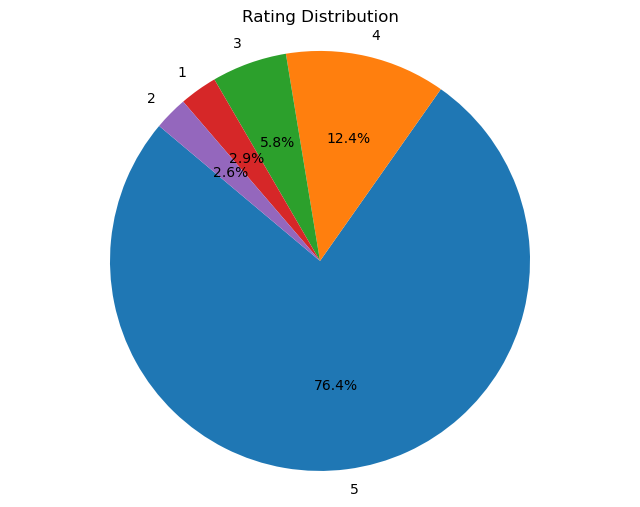

In [10]:
review_distribution = train_df['overall'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(review_distribution, labels=review_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Rating Distribution')
plt.axis('equal')
plt.show()

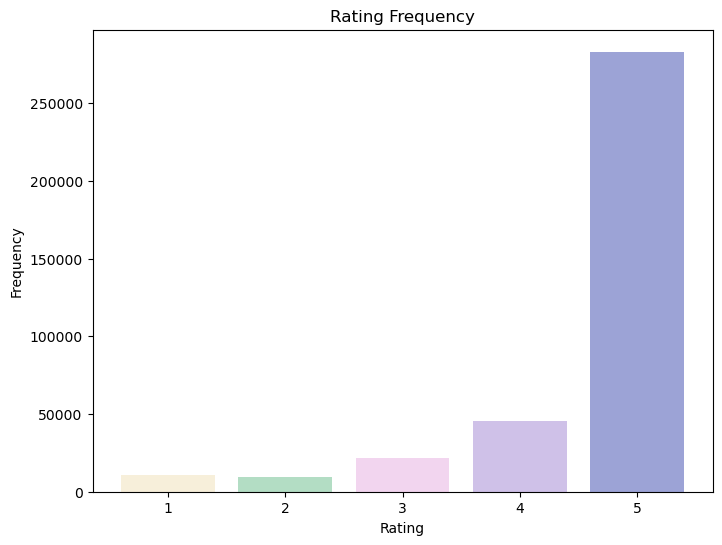

In [11]:
plt.figure(figsize=(8, 6))
# color=['#9CA3D6','#CFC1E8', '#F2D5EF', '#F7EFDA', '#B3DDC4']
plt.bar(review_distribution.index, review_distribution.values, color=['#9CA3D6','#CFC1E8', '#F2D5EF', '#F7EFDA', '#B3DDC4'])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Frequency')
plt.show()

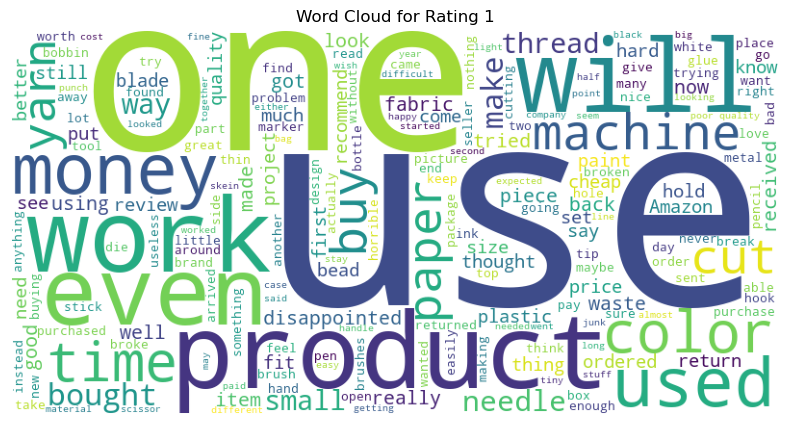

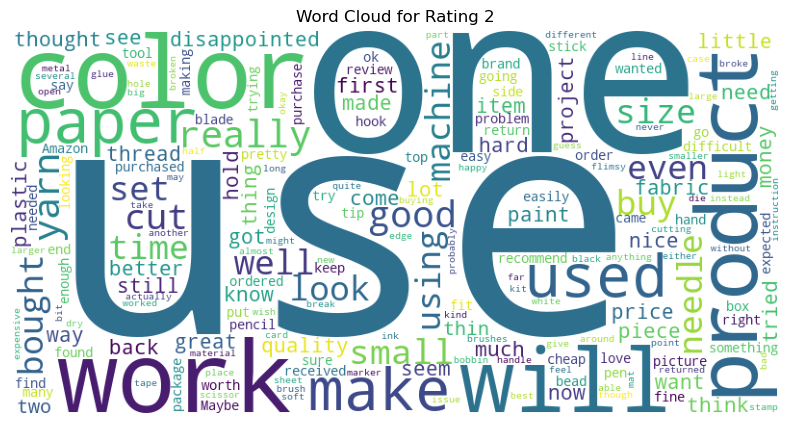

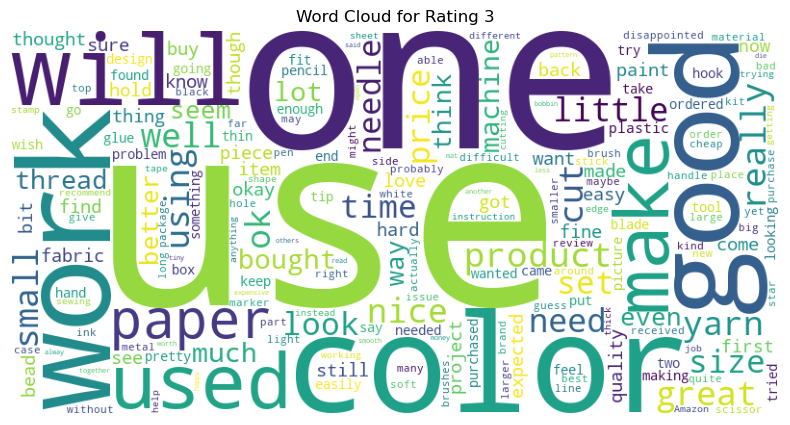

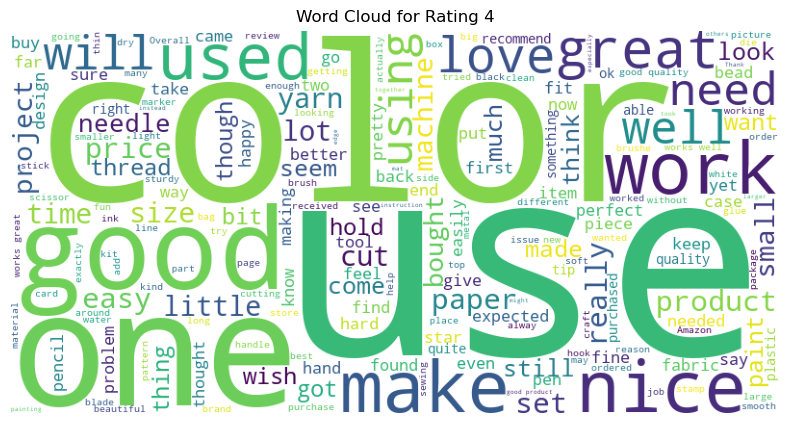

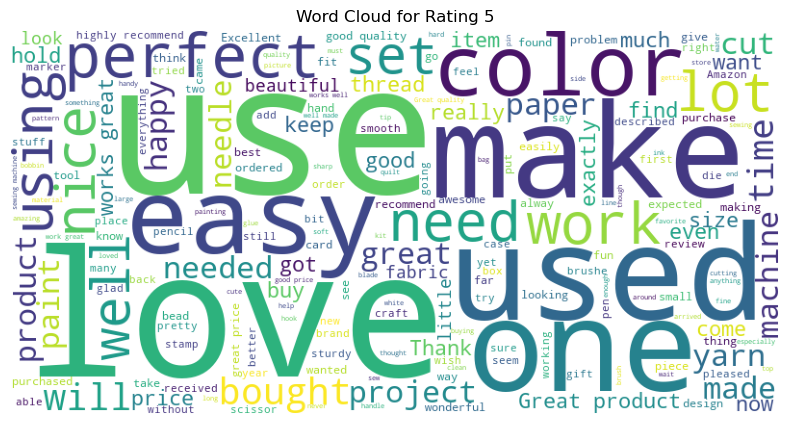

In [12]:
# Grouped in descending order
grouped = train_df.groupby('overall')

# Generate word cloud for each rating
for rating, group in grouped:
    text = ' '.join(group['Review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(f'Word Cloud for Rating {rating}')
    plt.axis('off')
    plt.show()

In [13]:
# train_df['text_length'] = train_df['Review'].apply(len)

# plt.figure(figsize=(10, 6))
# sns.boxplot(x='overall', y='text_length', data=train_df)
# plt.title('Length of Text for Each Rating')
# plt.xlabel('Rating')
# plt.ylabel('Text Length')
# plt.show()

## 2) Text Processing and Normalization:


In [14]:
def remove_punctuation(text):
    # Define the pattern to match punctuation
    punctuation_pattern = r'[^\w\s]'
    # Replace punctuation with an empty string
    text_without_punctuation = re.sub(punctuation_pattern, '', text)
    # Normalize whitespace
    normalized_text = re.sub(r'\s+', ' ', text_without_punctuation)
    return normalized_text

# Text Processing
def preprocess_text(text, method='snowballstemming'):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())

    # Define the set of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords and punctuation
    tokens = [remove_punctuation(token) for token in tokens if token.isalnum() and token not in stop_words]
    
    if method == 'snowballstemming':
        stemmer = nltk.stem.SnowballStemmer('english')
        tokens = [stemmer.stem(token) for token in tokens]

    elif method == 'porterstemming':
        stemmer = nltk.stem.PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    elif method == 'lemmatization':
        lemmatizer = nltk.stem.WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [15]:
train_df['ssprocessing_text'] = train_df['Review'].apply(preprocess_text, method='snowballstemming')
train_df['psprocessing_text'] = train_df['Review'].apply(preprocess_text, method='porterstemming')
train_df['lemprocessing_text'] = train_df['Review'].apply(preprocess_text, method='lemmatization')

In [16]:
train_df

overall                                             Review  \
0             5  I love these glitter pens. They sparkle deligh...   
1             5  It works well with my machine.  I use mostly c...   
2             5  This is a great assortment of colors, though t...   
3             5                       Just what I was looking for.   
4             5      I make 400 birds for the hospital each month.   
...         ...                                                ...   
370858        5  I love these dies they make great backgrounds ...   
370859        5  I love Darice embossing folders.  Darcie's fol...   
370860        5  I ordered these to add to my Earthy Markers th...   
370861        4  Made perfect off white color by blending a tin...   
370862        5  I used this to make photo canvases for Christm...   

                                        ssprocessing_text  \
0       love glitter pen sparkl delight page brilliant...   
1                          work well machin use most cone   
2       great assort color though lot pink mix still c...   
3                                                    look   
4                              make 400 bird hospit month   
...                                                   ...   
370858                love die make great background card   
370859  love daric emboss folder darci folder reason e...   
370860  order add earthi marker previous order want br...   
370861  made perfect white color blend tini amount yel...   
370862  use make photo canvas christma product realli ...   

                                        psprocessing_text  \
0       love glitter pen sparkl delight page brilliant...   
1                        work well machin use mostli cone   
2       great assort color though lot pink mix still c...   
3                                                    look   
4                              make 400 bird hospit month   
...                                                   ...   
370858                love die make great background card   
370859  love daric emboss folder darci folder reason e...   
370860  order add earthi marker previous order want br...   
370861  made perfect white color blend tini amount yel...   
370862  use make photo canvas christma product realli ...   

                                       lemprocessing_text  
0       love glitter pen sparkle delightfully page bri...  
1                       work well machine use mostly cone  
2       great assortment color though lot pink mix sti...  
3                                                 looking  
4                            make 400 bird hospital month  
...                                                   ...  
370858                 love dy make great background card  
370859  love darice embossing folder darcie folder rea...  
370860  ordered add earthy marker previously ordered w...  
370861  made perfect white color blending tiny amount ...  
370862  used make photo canvas christmas product reall...  

[370855 rows x 5 columns]

### Feature Representation - Reviews

In [17]:
# Counts number of times word appears in a sentence 
vect =  CountVectorizer()
subset_df=train_df['Review'][:5000]
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

Vocabulary size: 8242 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 4248, 'these': 7311, 'glitter': 3151, 'pens': 5155, 'they': 7314, 'sparkle': 6730, 'delightfully': 2003, 'on': 4882, 'the': 7293, 'page': 5022, 'and': 429, 're': 5708, 'brilliantly': 1032, 'coloured': 1510, 'even': 2566, 'without': 8085, 'darker': 1915, 'colours': 1511, 'do': 2210, 'bleed': 867, 'through': 7358, 'thin': 7322, 'paper': 5060, 'however': 3541, 'it': 3798, 'works': 8116, 'well': 7984, 'with': 8082, 'my': 4645, 'machine': 4282, 'use': 7746, 'mostly': 4599, 'cones': 1596, 'this': 7335, 'is': 3793, 'great': 3243, 'assortment': 575, 'of': 4848, 'colors': 1506, 'though': 7341, 'there': 7305, 'are': 520, 'lot': 4240, 'pinks': 5254, 'in': 3633, 'mix': 4544, 'still': 6922, 'most': 4598, 'covered': 1739, 'all': 375, 'those': 7340, 'spools': 6784, 'you': 8210, 'probably': 5506, 'not': 4779, 'going': 3173, 'to': 7417, 'have': 3377, 'problem': 5507, 'finding': 2817, 'color': 1497, 'that': 7291

In [18]:
# Checks if word appears in a sentence 
subset_df=train_df['Review'][:5000]
vect =  CountVectorizer(binary=True)
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense binary representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

Vocabulary size: 8242 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 4248, 'these': 7311, 'glitter': 3151, 'pens': 5155, 'they': 7314, 'sparkle': 6730, 'delightfully': 2003, 'on': 4882, 'the': 7293, 'page': 5022, 'and': 429, 're': 5708, 'brilliantly': 1032, 'coloured': 1510, 'even': 2566, 'without': 8085, 'darker': 1915, 'colours': 1511, 'do': 2210, 'bleed': 867, 'through': 7358, 'thin': 7322, 'paper': 5060, 'however': 3541, 'it': 3798, 'works': 8116, 'well': 7984, 'with': 8082, 'my': 4645, 'machine': 4282, 'use': 7746, 'mostly': 4599, 'cones': 1596, 'this': 7335, 'is': 3793, 'great': 3243, 'assortment': 575, 'of': 4848, 'colors': 1506, 'though': 7341, 'there': 7305, 'are': 520, 'lot': 4240, 'pinks': 5254, 'in': 3633, 'mix': 4544, 'still': 6922, 'most': 4598, 'covered': 1739, 'all': 375, 'those': 7340, 'spools': 6784, 'you': 8210, 'probably': 5506, 'not': 4779, 'going': 3173, 'to': 7417, 'have': 3377, 'problem': 5507, 'finding': 2817, 'color': 1497, 'that': 7291

In [19]:
# Checks tf in a corpus by the number of times words appear
subset_df=train_df['Review'][:5000]
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '000' '00mm' ... 'zippers' 'zips' 'zutter']
Vocabulary size: 8242 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 4248, 'these': 7311, 'glitter': 3151, 'pens': 5155, 'they': 7314, 'sparkle': 6730, 'delightfully': 2003, 'on': 4882, 'the': 7293, 'page': 5022, 'and': 429, 're': 5708, 'brilliantly': 1032, 'coloured': 1510, 'even': 2566, 'without': 8085, 'darker': 1915, 'colours': 1511, 'do': 2210, 'bleed': 867, 'through': 7358, 'thin': 7322, 'paper': 5060, 'however': 3541, 'it': 3798, 'works': 8116, 'well': 7984, 'with': 8082, 'my': 4645, 'machine': 4282, 'use': 7746, 'mostly': 4599, 'cones': 1596, 'this': 7335, 'is': 3793, 'great': 3243, 'assortment': 575, 'of': 4848, 'colors': 1506, 'though': 7341, 'there': 7305, 'are': 520, 'lot': 4240, 'pinks': 5254, 'in': 3633, 'mix': 4544, 'still': 6922, 'most': 4598, 'covered': 1739, 'all': 375, 'those': 7340, 'spools': 6784, 'you': 8210, 'probably': 5506, 'not': 4779, 'going': 3173, 'to': 7417, 'have': 3377, 'problem': 

the             293.697341
great           279.214012
it              258.941628
and             233.640044
to              223.902176
                   ...    
auxiliary         0.033749
disadvantage      0.033749
assumes           0.033749
fancier           0.033749
screwdriver       0.033749
Length: 8242, dtype: float64

In [20]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['Review'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '000' '00mm' ... 'zippers' 'zips' 'zutter']
Vocabulary size: 8242 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 4248, 'these': 7311, 'glitter': 3151, 'pens': 5155, 'they': 7314, 'sparkle': 6730, 'delightfully': 2003, 'on': 4882, 'the': 7293, 'page': 5022, 'and': 429, 're': 5708, 'brilliantly': 1032, 'coloured': 1510, 'even': 2566, 'without': 8085, 'darker': 1915, 'colours': 1511, 'do': 2210, 'bleed': 867, 'through': 7358, 'thin': 7322, 'paper': 5060, 'however': 3541, 'it': 3798, 'works': 8116, 'well': 7984, 'with': 8082, 'my': 4645, 'machine': 4282, 'use': 7746, 'mostly': 4599, 'cones': 1596, 'this': 7335, 'is': 3793, 'great': 3243, 'assortment': 575, 'of': 4848, 'colors': 1506, 'though': 7341, 'there': 7305, 'are': 520, 'lot': 4240, 'pinks': 5254, 'in': 3633, 'mix': 4544, 'still': 6922, 'most': 4598, 'covered': 1739, 'all': 375, 'those': 7340, 'spools': 6784, 'you': 8210, 'probably': 5506, 'not': 4779, 'going': 3173, 'to': 7417, 'have': 3377, 'problem': 

the             293.697341
great           279.214012
it              258.941628
and             233.640044
to              223.902176
                   ...    
auxiliary         0.033749
disadvantage      0.033749
assumes           0.033749
fancier           0.033749
screwdriver       0.033749
Length: 8242, dtype: float64

In [21]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['Review'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '00 chinese' '00 dollars' ... 'zips so' 'zutter' 'zutter bind']
Vocabulary size: 74479 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 35047, 'these': 63137, 'glitter': 24636, 'pens': 46066, 'they': 63476, 'sparkle': 57057, 'delightfully': 16027, 'on': 42363, 'the': 60870, 'page': 44936, 'and': 2901, 're': 50100, 'brilliantly': 9791, 'coloured': 13242, 'even': 19578, 'without': 72660, 'darker': 15587, 'colours': 13248, 'do': 17150, 'bleed': 8744, 'through': 64816, 'thin': 63735, 'paper': 45344, 'however': 28387, 'love these': 35120, 'these glitter': 63255, 'glitter pens': 24652, 'pens they': 46103, 'they sparkle': 63621, 'sparkle delightfully': 57058, 'delightfully on': 16028, 'on the': 42671, 'the page': 61952, 'page and': 44938, 'and they': 3992, 'they re': 63596, 're brilliantly': 50111, 'brilliantly coloured': 9792, 'coloured even': 13244, 'even without': 19692, 'without the': 72715, 'the glitter': 61534, 'glitter the': 24659, 'the darker': 61289, 'dark

great              186.177715
the                167.137437
it                 145.929881
and                130.611025
to                 126.064500
                      ...    
100 2045             0.024698
needle plate         0.024698
needle this          0.024698
14 tall              0.024698
common problems      0.024698
Length: 74479, dtype: float64

In [22]:
subset_df=train_df['Review'][:5000]
vectorizer = TfidfVectorizer(min_df=0.008,max_df=0.2,ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
dense_vec = vectors.todense()
dense_list = dense_vec.tolist()
# Display Tf-idf with min_i
tfidf_data = pd.DataFrame(dense_list, columns=feature_names) 
tfidf_data
tfidf_data.sort_values(by=['bought','perfect'],ascending=False)

10  able  able to     about  absolutely  actually       add     after  \
4937  0.0   0.0      0.0  0.000000         0.0       0.0  0.000000  0.000000   
1804  0.0   0.0      0.0  0.000000         0.0       0.0  0.000000  0.000000   
3951  0.0   0.0      0.0  0.000000         0.0       0.0  0.000000  0.000000   
4580  0.0   0.0      0.0  0.000000         0.0       0.0  0.000000  0.000000   
3760  0.0   0.0      0.0  0.000000         0.0       0.0  0.000000  0.000000   
...   ...   ...      ...       ...         ...       ...       ...       ...   
4995  0.0   0.0      0.0  0.000000         0.0       0.0  0.000000  0.000000   
4996  0.0   0.0      0.0  0.000000         0.0       0.0  0.217808  0.000000   
4997  0.0   0.0      0.0  0.136563         0.0       0.0  0.000000  0.142143   
4998  0.0   0.0      0.0  0.000000         0.0       0.0  0.000000  0.000000   
4999  0.0   0.0      0.0  0.000000         0.0       0.0  0.000000  0.000000   

      again       all  ...  you  you are  you can  you get  you have  \
4937    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   
1804    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   
3951    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   
4580    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   
3760    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   
...     ...       ...  ...  ...      ...      ...      ...       ...   
4995    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   
4996    0.0  0.136019  ...  0.0      0.0      0.0      0.0       0.0   
4997    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   
4998    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   
4999    0.0  0.000000  ...  0.0      0.0      0.0      0.0       0.0   

      you need  you re  you want  you will  your  
4937       0.0     0.0       0.0       0.0   0.0  
1804       0.0     0.0       0.0       0.0   0.0  
3951       0.0     0.0       0.0       0.0   0.0  
4580       0.0     0.0       0.0       0.0   0.0  
3760       0.0     0.0       0.0       0.0   0.0  
...        ...     ...       ...       ...   ...  
4995       0.0     0.0       0.0       0.0   0.0  
4996       0.0     0.0       0.0       0.0   0.0  
4997       0.0     0.0       0.0       0.0   0.0  
4998       0.0     0.0       0.0       0.0   0.0  
4999       0.0     0.0       0.0       0.0   0.0  

[5000 rows x 657 columns]

In [23]:
subset_df=train_df['Review'][:5000]
X_train = vectorizer.transform(subset_df)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['want to' 'you will' 'if' 'is that' 'you need' 'other' 'and have'
 'that is' 'have to' 'how to' 'want' 'because' 'if you' 'so it' 'been'
 'there is' 'sure' 'that you' 'need to' 'it the']
Features with highest tfidf: 
['look' 'long' 'size' 'small' 'smooth' 'like' 'very' 'cut' 'variety'
 'value' 'stamps' 'cute' 'job' 'strong' 'daughter' 'deal' 'stuff' 'super'
 'item' 'these']


In [24]:
import gensim
from nltk.tokenize import word_tokenize

subset_df = train_df['Review'][:5000].dropna()
subset_df["tokens"] = subset_df.apply(word_tokenize)

# Train Word2Vec and FastText models
model_w2v = gensim.models.Word2Vec(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)
model_ft = gensim.models.FastText(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)

# Save the models to disk
model_w2v.save("model_w2v.model")
model_ft.save("model_ft.model")

# Load the models from disk
model_w2v = gensim.models.Word2Vec.load("model_w2v.model")
model_ft = gensim.models.FastText.load("model_ft.model")

In [25]:
# Now you can use the most_similar method
print("Words similar to \"pen\"\n", model_w2v.wv.most_similar("pen", topn=5))
print("Words similar to  \"paper\" and \"cover\"\n",model_w2v.wv.most_similar(positive=['paper', 'cover'], topn=5))
print("Words similar to \"pen\" and \"marker\"\n",model_w2v.wv.most_similar(positive=['pen', 'marker'], topn=5))
print("Words similar to  \"marker\" and \"pen\" and disimilar to \"machine\"\n",model_w2v.wv.most_similar(positive=['marker', 'pen'], negative=['machine'], topn=5))

Words similar to "pen"
 [('material', 0.9987937808036804), ('brush', 0.998611330986023), ('point', 0.9985246658325195), ('plus', 0.9982461929321289), ('book', 0.9981805682182312)]
Words similar to  "paper" and "cover"
 [('piece', 0.9989009499549866), ('cutting', 0.9973616600036621), ('being', 0.9970657825469971), ('sheet', 0.9970590472221375), ('line', 0.9970470666885376)]
Words similar to "pen" and "marker"
 [('mixing', 0.9988172650337219), ('package', 0.9986370205879211), ('tiny', 0.9986054301261902), ('point', 0.9985654354095459), ('plus', 0.9985431432723999)]
Words similar to  "marker" and "pen" and disimilar to "machine"
 [('sharp', 0.9838315844535828), ('smooth', 0.9816608428955078), ('beads', 0.981532871723175), ('comfortable', 0.9808623790740967), ('blend', 0.9802640676498413)]


### Feature Representation - Snowball Stemmer

In [26]:
# Counts number of times word appears in a sentence 
vect =  CountVectorizer()
subset_df=train_df['ssprocessing_text'][:5000]
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

Vocabulary size: 5350 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 2758, 'glitter': 2041, 'pen': 3359, 'sparkl': 4338, 'delight': 1312, 'page': 3275, 'brilliant': 686, 'colour': 1008, 'even': 1662, 'without': 5235, 'darker': 1257, 'bleed': 580, 'thin': 4711, 'paper': 3298, 'howev': 2311, 'work': 5254, 'well': 5168, 'machin': 2782, 'use': 5008, 'most': 2987, 'cone': 1062, 'great': 2115, 'assort': 389, 'color': 1003, 'though': 4722, 'lot': 2752, 'pink': 3425, 'mix': 2951, 'still': 4453, 'cover': 1141, 'spool': 4373, 'probabl': 3584, 'go': 2054, 'problem': 3585, 'find': 1815, 'project': 3601, 'buy': 758, 'futur': 1975, 'one': 3192, 'look': 2740, 'make': 2805, '400': 85, 'bird': 561, 'hospit': 2303, 'month': 2980, 'sharp': 4122, 'replac': 3803, 'blade': 572, 'valu': 5031, 'okay': 3181, 'plastic': 3446, 'bit': 565, 'thick': 4707, 'textur': 4691, 'get': 2019, 'clear': 955, 'imag': 2353, 'say': 3986, 'star': 4410, 'daughter': 1263, 'paint': 3279, 'lift': 2687, 'defin

In [27]:
# Checks if word appears in a sentence 
subset_df=train_df['ssprocessing_text'][:5000]
vect =  CountVectorizer(binary=True)
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense binary representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

Vocabulary size: 5350 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 2758, 'glitter': 2041, 'pen': 3359, 'sparkl': 4338, 'delight': 1312, 'page': 3275, 'brilliant': 686, 'colour': 1008, 'even': 1662, 'without': 5235, 'darker': 1257, 'bleed': 580, 'thin': 4711, 'paper': 3298, 'howev': 2311, 'work': 5254, 'well': 5168, 'machin': 2782, 'use': 5008, 'most': 2987, 'cone': 1062, 'great': 2115, 'assort': 389, 'color': 1003, 'though': 4722, 'lot': 2752, 'pink': 3425, 'mix': 2951, 'still': 4453, 'cover': 1141, 'spool': 4373, 'probabl': 3584, 'go': 2054, 'problem': 3585, 'find': 1815, 'project': 3601, 'buy': 758, 'futur': 1975, 'one': 3192, 'look': 2740, 'make': 2805, '400': 85, 'bird': 561, 'hospit': 2303, 'month': 2980, 'sharp': 4122, 'replac': 3803, 'blade': 572, 'valu': 5031, 'okay': 3181, 'plastic': 3446, 'bit': 565, 'thick': 4707, 'textur': 4691, 'get': 2019, 'clear': 955, 'imag': 2353, 'say': 3986, 'star': 4410, 'daughter': 1263, 'paint': 3279, 'lift': 2687, 'defin

In [28]:
# Checks tf in a corpus by the number of times words appear
subset_df=train_df['ssprocessing_text'][:5000]
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '000' '06' ... 'ziplock' 'zipper' 'zutter']
Vocabulary size: 5350 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 2758, 'glitter': 2041, 'pen': 3359, 'sparkl': 4338, 'delight': 1312, 'page': 3275, 'brilliant': 686, 'colour': 1008, 'even': 1662, 'without': 5235, 'darker': 1257, 'bleed': 580, 'thin': 4711, 'paper': 3298, 'howev': 2311, 'work': 5254, 'well': 5168, 'machin': 2782, 'use': 5008, 'most': 2987, 'cone': 1062, 'great': 2115, 'assort': 389, 'color': 1003, 'though': 4722, 'lot': 2752, 'pink': 3425, 'mix': 2951, 'still': 4453, 'cover': 1141, 'spool': 4373, 'probabl': 3584, 'go': 2054, 'problem': 3585, 'find': 1815, 'project': 3601, 'buy': 758, 'futur': 1975, 'one': 3192, 'look': 2740, 'make': 2805, '400': 85, 'bird': 561, 'hospit': 2303, 'month': 2980, 'sharp': 4122, 'replac': 3803, 'blade': 572, 'valu': 5031, 'okay': 3181, 'plastic': 3446, 'bit': 565, 'thick': 4707, 'textur': 4691, 'get': 2019, 'clear': 955, 'imag': 2353, 'say': 3986, 'star': 4410, 'da

great      314.900960
love       243.529988
good       193.549340
use        183.006276
work       168.677990
              ...    
2020         0.041254
tempt        0.041254
text         0.041254
underpl      0.041254
fancier      0.041254
Length: 5350, dtype: float64

In [29]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['ssprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '000' '06' ... 'ziplock' 'zipper' 'zutter']
Vocabulary size: 5350 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 2758, 'glitter': 2041, 'pen': 3359, 'sparkl': 4338, 'delight': 1312, 'page': 3275, 'brilliant': 686, 'colour': 1008, 'even': 1662, 'without': 5235, 'darker': 1257, 'bleed': 580, 'thin': 4711, 'paper': 3298, 'howev': 2311, 'work': 5254, 'well': 5168, 'machin': 2782, 'use': 5008, 'most': 2987, 'cone': 1062, 'great': 2115, 'assort': 389, 'color': 1003, 'though': 4722, 'lot': 2752, 'pink': 3425, 'mix': 2951, 'still': 4453, 'cover': 1141, 'spool': 4373, 'probabl': 3584, 'go': 2054, 'problem': 3585, 'find': 1815, 'project': 3601, 'buy': 758, 'futur': 1975, 'one': 3192, 'look': 2740, 'make': 2805, '400': 85, 'bird': 561, 'hospit': 2303, 'month': 2980, 'sharp': 4122, 'replac': 3803, 'blade': 572, 'valu': 5031, 'okay': 3181, 'plastic': 3446, 'bit': 565, 'thick': 4707, 'textur': 4691, 'get': 2019, 'clear': 955, 'imag': 2353, 'say': 3986, 'star': 4410, 'da

great      314.900960
love       243.529988
good       193.549340
use        183.006276
work       168.677990
              ...    
2020         0.041254
tempt        0.041254
text         0.041254
underpl      0.041254
fancier      0.041254
Length: 5350, dtype: float64

In [30]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['ssprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '00 know' '000' ... 'zipper work' 'zutter' 'zutter accompani']
Vocabulary size: 57634 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 27889, 'glitter': 19744, 'pen': 35433, 'sparkl': 46503, 'delight': 12258, 'page': 34374, 'brilliant': 6387, 'colour': 9476, 'even': 15364, 'without': 55958, 'darker': 11817, 'bleed': 5261, 'thin': 49923, 'paper': 34804, 'howev': 22986, 'love glitter': 28044, 'glitter pen': 19763, 'pen sparkl': 35509, 'sparkl delight': 46506, 'delight page': 12260, 'page brilliant': 34379, 'brilliant colour': 6389, 'colour even': 9485, 'even without': 15512, 'without glitter': 55987, 'glitter darker': 19746, 'darker colour': 11820, 'colour bleed': 9479, 'bleed thin': 5268, 'thin paper': 49954, 'paper howev': 34888, 'work': 56284, 'well': 55122, 'machin': 28408, 'use': 52918, 'most': 30899, 'cone': 10009, 'work well': 56573, 'well machin': 55265, 'machin use': 28611, 'use most': 53368, 'most cone': 30903, 'great': 20735, 'assort': 3067, 'color'

great                209.118047
love                 166.969732
good                 133.938614
use                  105.406794
work                  97.966209
                        ...    
felt disk              0.031481
feet gave              0.031481
straight stitch        0.031481
run someth             0.031481
instruct instruct      0.031481
Length: 57634, dtype: float64

In [31]:
subset_df=train_df['ssprocessing_text'][:5000]
vectorizer = TfidfVectorizer(min_df=0.008,max_df=0.2,ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
dense_vec = vectors.todense()
dense_list = dense_vec.tolist()
# Display Tf-idf with min_i
tfidf_data = pd.DataFrame(dense_list, columns=feature_names) 
tfidf_data
tfidf_data.sort_values(by=['bought','perfect'],ascending=False)

abl  absolut  acryl  actual       add  almost  alreadi      also  alway  \
3882  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
1804  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
1524  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
1585  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
219   0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.276501    0.0   
...   ...      ...    ...     ...       ...     ...      ...       ...    ...   
4995  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
4996  0.0      0.0    0.0     0.0  0.281423     0.0      0.0  0.000000    0.0   
4997  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
4998  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
4999  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   

      amaz  ...      work  work great  work perfect  work well  worth  would  \
3882   0.0  ...  0.000000         0.0           0.0   0.000000    0.0    0.0   
1804   0.0  ...  0.000000         0.0           0.0   0.000000    0.0    0.0   
1524   0.0  ...  0.187656         0.0           0.0   0.000000    0.0    0.0   
1585   0.0  ...  0.000000         0.0           0.0   0.000000    0.0    0.0   
219    0.0  ...  0.369751         0.0           0.0   0.298090    0.0    0.0   
...    ...  ...       ...         ...           ...        ...    ...    ...   
4995   0.0  ...  0.000000         0.0           0.0   0.000000    0.0    0.0   
4996   0.0  ...  0.000000         0.0           0.0   0.000000    0.0    0.0   
4997   0.0  ...  0.127522         0.0           0.0   0.205614    0.0    0.0   
4998   0.0  ...  0.000000         0.0           0.0   0.000000    0.0    0.0   
4999   0.0  ...  0.000000         0.0           0.0   0.000000    0.0    0.0   

      would recommend      yarn      year  yet  
3882              0.0  0.000000  0.000000  0.0  
1804              0.0  0.000000  0.000000  0.0  
1524              0.0  0.000000  0.000000  0.0  
1585              0.0  0.000000  0.000000  0.0  
219               0.0  0.000000  0.000000  0.0  
...               ...       ...       ...  ...  
4995              0.0  0.000000  0.000000  0.0  
4996              0.0  0.000000  0.000000  0.0  
4997              0.0  0.000000  0.217717  0.0  
4998              0.0  0.673891  0.000000  0.0  
4999              0.0  0.000000  0.000000  0.0  

[5000 rows x 348 columns]

In [32]:
subset_df=train_df['ssprocessing_text'][:5000]
X_train = vectorizer.transform(subset_df)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['day' 'amount' 'year' 'break' 'full' 'may' 'other' 'anyon' 'wo' 'pull'
 'longer' 'two' 'everi' 'part' 'especi' 'remov' 'close' 'disappoint'
 'result' 'second']
Features with highest tfidf: 
['handi' 'happi' 'hard' 'ink' 'item' 'job' 'knit' 'right' 'leav' 'like'
 'look' 'lot' 'love' 'machin' 'made' 'make' 'materi' 'much' 'light'
 'littl']


In [33]:
import gensim
from nltk.tokenize import word_tokenize

subset_df = train_df['ssprocessing_text'][:5000].dropna()
subset_df["tokens"] = subset_df.apply(word_tokenize)

# Train Word2Vec and FastText models
model_w2v = gensim.models.Word2Vec(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)
model_ft = gensim.models.FastText(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)

# Save the models to disk
model_w2v.save("model_w2v.model")
model_ft.save("model_ft.model")

# Load the models from disk
model_w2v = gensim.models.Word2Vec.load("model_w2v.model")
model_ft = gensim.models.FastText.load("model_ft.model")

In [37]:
# Now you can use the most_similar method
print("Words similar to \"pen\"\n", model_w2v.wv.most_similar("pen", topn=5))
print("Words similar to  \"paper\" and \"cover\"\n",model_w2v.wv.most_similar(positive=['paper', 'cover'], topn=5))
print("Words similar to \"pen\" and \"marker\"\n",model_w2v.wv.most_similar(positive=['pen', 'marker'], topn=5))

# not sure about this - the negative board
print("Words similar to  \"marker\" and \"pen\" and disimilar to \"board\"\n",model_w2v.wv.most_similar(positive=['marker', 'pen'], negative=['board'], topn=5))

Words similar to "pen"
 [('watercolor', 0.999622642993927), ('set', 0.9995218515396118), ('marker', 0.999507486820221), ('water', 0.999437153339386), ('artist', 0.9994090795516968)]
Words similar to  "paper" and "cover"
 [('line', 0.9996628165245056), ('easili', 0.999626636505127), ('see', 0.9996243715286255), ('piec', 0.9995970129966736), ('help', 0.9995851516723633)]
Words similar to "pen" and "marker"
 [('watercolor', 0.9996452331542969), ('set', 0.9996330142021179), ('blend', 0.9995247721672058), ('water', 0.9995000958442688), ('artist', 0.9994993209838867)]
Words similar to  "marker" and "pen" and disimilar to "board"
 [('color', 0.998461902141571), ('pencil', 0.9984367489814758), ('brush', 0.9979427456855774), ('watercolor', 0.9979043006896973), ('paint', 0.9974149465560913)]


### Feature Representation - Porter Stemmer

In [38]:
# Counts number of times word appears in a sentence 
vect =  CountVectorizer()
subset_df=train_df['psprocessing_text'][:5000]
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

Vocabulary size: 5410 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 2779, 'glitter': 2056, 'pen': 3391, 'sparkl': 4390, 'delight': 1323, 'page': 3306, 'brilliantli': 688, 'colour': 1015, 'even': 1671, 'without': 5297, 'darker': 1267, 'bleed': 581, 'thin': 4769, 'paper': 3330, 'howev': 2331, 'work': 5316, 'well': 5230, 'machin': 2803, 'use': 5069, 'mostli': 3011, 'cone': 1070, 'great': 2130, 'assort': 389, 'color': 1010, 'though': 4781, 'lot': 2773, 'pink': 3458, 'mix': 2974, 'still': 4506, 'cover': 1151, 'spool': 4426, 'probabl': 3620, 'go': 2069, 'problem': 3621, 'find': 1827, 'project': 3637, 'buy': 760, 'futur': 1991, 'one': 3221, 'look': 2761, 'make': 2828, '400': 85, 'bird': 562, 'hospit': 2323, 'month': 3003, 'sharp': 4170, 'replac': 3846, 'blade': 573, 'valu': 5092, 'okay': 3210, 'plastic': 3479, 'bit': 566, 'thick': 4765, 'textur': 4749, 'get': 2034, 'clear': 960, 'imag': 2372, 'say': 4032, 'star': 4463, 'daughter': 1273, 'paint': 3310, 'lift': 2707, 'd

In [39]:
# Checks if word appears in a sentence 
subset_df=train_df['psprocessing_text'][:5000]
vect =  CountVectorizer(binary=True)
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense binary representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

Vocabulary size: 5410 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 2779, 'glitter': 2056, 'pen': 3391, 'sparkl': 4390, 'delight': 1323, 'page': 3306, 'brilliantli': 688, 'colour': 1015, 'even': 1671, 'without': 5297, 'darker': 1267, 'bleed': 581, 'thin': 4769, 'paper': 3330, 'howev': 2331, 'work': 5316, 'well': 5230, 'machin': 2803, 'use': 5069, 'mostli': 3011, 'cone': 1070, 'great': 2130, 'assort': 389, 'color': 1010, 'though': 4781, 'lot': 2773, 'pink': 3458, 'mix': 2974, 'still': 4506, 'cover': 1151, 'spool': 4426, 'probabl': 3620, 'go': 2069, 'problem': 3621, 'find': 1827, 'project': 3637, 'buy': 760, 'futur': 1991, 'one': 3221, 'look': 2761, 'make': 2828, '400': 85, 'bird': 562, 'hospit': 2323, 'month': 3003, 'sharp': 4170, 'replac': 3846, 'blade': 573, 'valu': 5092, 'okay': 3210, 'plastic': 3479, 'bit': 566, 'thick': 4765, 'textur': 4749, 'get': 2034, 'clear': 960, 'imag': 2372, 'say': 4032, 'star': 4463, 'daughter': 1273, 'paint': 3310, 'lift': 2707, 'd

In [40]:
# Checks tf in a corpus by the number of times words appear
subset_df=train_df['psprocessing_text'][:5000]
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '000' '06' ... 'ziplock' 'zipper' 'zutter']
Vocabulary size: 5410 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 2779, 'glitter': 2056, 'pen': 3391, 'sparkl': 4390, 'delight': 1323, 'page': 3306, 'brilliantli': 688, 'colour': 1015, 'even': 1671, 'without': 5297, 'darker': 1267, 'bleed': 581, 'thin': 4769, 'paper': 3330, 'howev': 2331, 'work': 5316, 'well': 5230, 'machin': 2803, 'use': 5069, 'mostli': 3011, 'cone': 1070, 'great': 2130, 'assort': 389, 'color': 1010, 'though': 4781, 'lot': 2773, 'pink': 3458, 'mix': 2974, 'still': 4506, 'cover': 1151, 'spool': 4426, 'probabl': 3620, 'go': 2069, 'problem': 3621, 'find': 1827, 'project': 3637, 'buy': 760, 'futur': 1991, 'one': 3221, 'look': 2761, 'make': 2828, '400': 85, 'bird': 562, 'hospit': 2323, 'month': 3003, 'sharp': 4170, 'replac': 3846, 'blade': 573, 'valu': 5092, 'okay': 3210, 'plastic': 3479, 'bit': 566, 'thick': 4765, 'textur': 4749, 'get': 2034, 'clear': 960, 'imag': 2372, 'say': 4032, 'star': 4463,

great        314.430637
love         243.013196
good         193.341035
use          182.476244
work         168.017309
                ...    
2045           0.041239
slope          0.041239
auxiliari      0.041239
text           0.041239
fancier        0.041239
Length: 5410, dtype: float64

In [41]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['psprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '000' '06' ... 'ziplock' 'zipper' 'zutter']
Vocabulary size: 5410 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 2779, 'glitter': 2056, 'pen': 3391, 'sparkl': 4390, 'delight': 1323, 'page': 3306, 'brilliantli': 688, 'colour': 1015, 'even': 1671, 'without': 5297, 'darker': 1267, 'bleed': 581, 'thin': 4769, 'paper': 3330, 'howev': 2331, 'work': 5316, 'well': 5230, 'machin': 2803, 'use': 5069, 'mostli': 3011, 'cone': 1070, 'great': 2130, 'assort': 389, 'color': 1010, 'though': 4781, 'lot': 2773, 'pink': 3458, 'mix': 2974, 'still': 4506, 'cover': 1151, 'spool': 4426, 'probabl': 3620, 'go': 2069, 'problem': 3621, 'find': 1827, 'project': 3637, 'buy': 760, 'futur': 1991, 'one': 3221, 'look': 2761, 'make': 2828, '400': 85, 'bird': 562, 'hospit': 2323, 'month': 3003, 'sharp': 4170, 'replac': 3846, 'blade': 573, 'valu': 5092, 'okay': 3210, 'plastic': 3479, 'bit': 566, 'thick': 4765, 'textur': 4749, 'get': 2034, 'clear': 960, 'imag': 2372, 'say': 4032, 'star': 4463,

great        314.430637
love         243.013196
good         193.341035
use          182.476244
work         168.017309
                ...    
2045           0.041239
slope          0.041239
auxiliari      0.041239
text           0.041239
fancier        0.041239
Length: 5410, dtype: float64

In [42]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['psprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '00 know' '000' ... 'zipper work' 'zutter' 'zutter accompani']
Vocabulary size: 57786 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 27938, 'glitter': 19776, 'pen': 35497, 'sparkl': 46629, 'delight': 12281, 'page': 34436, 'brilliantli': 6397, 'colour': 9491, 'even': 15383, 'without': 56109, 'darker': 11838, 'bleed': 5266, 'thin': 50060, 'paper': 34867, 'howev': 23030, 'love glitter': 28093, 'glitter pen': 19795, 'pen sparkl': 35573, 'sparkl delight': 46632, 'delight page': 12283, 'page brilliantli': 34441, 'brilliantli colour': 6398, 'colour even': 9500, 'even without': 15528, 'without glitter': 56138, 'glitter darker': 19778, 'darker colour': 11841, 'colour bleed': 9494, 'bleed thin': 5273, 'thin paper': 50091, 'paper howev': 34951, 'work': 56435, 'well': 55272, 'machin': 28458, 'use': 53059, 'mostli': 30953, 'cone': 10025, 'work well': 56726, 'well machin': 55415, 'machin use': 28662, 'use mostli': 53512, 'mostli cone': 30957, 'great': 20771, 'assort': 3

great           208.993040
love            166.818618
good            133.890854
use             105.250889
work             97.634692
                   ...    
needl might       0.031473
needl plate       0.031473
needl show        0.031473
needl variou      0.031473
review sew        0.031473
Length: 57786, dtype: float64

In [43]:
subset_df=train_df['psprocessing_text'][:5000]
vectorizer = TfidfVectorizer(min_df=0.008,max_df=0.2,ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
dense_vec = vectors.todense()
dense_list = dense_vec.tolist()
# Display Tf-idf with min_i
tfidf_data = pd.DataFrame(dense_list, columns=feature_names) 
tfidf_data
tfidf_data.sort_values(by=['bought','perfect'],ascending=False)

abl  absolut  acryl  actual       add  almost  alreadi      also  alway  \
3882  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
1804  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
1524  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
1585  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
219   0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.276501    0.0   
...   ...      ...    ...     ...       ...     ...      ...       ...    ...   
4995  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
4996  0.0      0.0    0.0     0.0  0.281423     0.0      0.0  0.000000    0.0   
4997  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
4998  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   
4999  0.0      0.0    0.0     0.0  0.000000     0.0      0.0  0.000000    0.0   

      amaz  ...  wonder      work  work great  work well  worth  would  \
3882   0.0  ...     0.0  0.000000         0.0   0.000000    0.0    0.0   
1804   0.0  ...     0.0  0.000000         0.0   0.000000    0.0    0.0   
1524   0.0  ...     0.0  0.187656         0.0   0.000000    0.0    0.0   
1585   0.0  ...     0.0  0.000000         0.0   0.000000    0.0    0.0   
219    0.0  ...     0.0  0.369751         0.0   0.298090    0.0    0.0   
...    ...  ...     ...       ...         ...        ...    ...    ...   
4995   0.0  ...     0.0  0.000000         0.0   0.000000    0.0    0.0   
4996   0.0  ...     0.0  0.000000         0.0   0.000000    0.0    0.0   
4997   0.0  ...     0.0  0.127511         0.0   0.205597    0.0    0.0   
4998   0.0  ...     0.0  0.000000         0.0   0.000000    0.0    0.0   
4999   0.0  ...     0.0  0.000000         0.0   0.000000    0.0    0.0   

      would recommend      yarn    year  yet  
3882              0.0  0.000000  0.0000  0.0  
1804              0.0  0.000000  0.0000  0.0  
1524              0.0  0.000000  0.0000  0.0  
1585              0.0  0.000000  0.0000  0.0  
219               0.0  0.000000  0.0000  0.0  
...               ...       ...     ...  ...  
4995              0.0  0.000000  0.0000  0.0  
4996              0.0  0.000000  0.0000  0.0  
4997              0.0  0.000000  0.2177  0.0  
4998              0.0  0.673891  0.0000  0.0  
4999              0.0  0.000000  0.0000  0.0  

[5000 rows x 348 columns]

In [44]:
subset_df=train_df['psprocessing_text'][:5000]
X_train = vectorizer.transform(subset_df)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['day' 'amount' 'full' 'year' 'break' 'may' 'other' 'anyon' 'wo' 'pull'
 'longer' 'two' 'everi' 'especi' 'part' 'close' 'result' 'second' 'put'
 'tini']
Features with highest tfidf: 
['good' 'handi' 'happi' 'hard' 'ink' 'item' 'job' 'knit' 'leav' 'light'
 'like' 'look' 'lot' 'love' 'machin' 'made' 'make' 'materi' 'need' 'littl']


In [45]:
import gensim
from nltk.tokenize import word_tokenize

subset_df = train_df['psprocessing_text'][:5000].dropna()
subset_df["tokens"] = subset_df.apply(word_tokenize)

# Train Word2Vec and FastText models
model_w2v = gensim.models.Word2Vec(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)
model_ft = gensim.models.FastText(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)

# Save the models to disk
model_w2v.save("model_w2v.model")
model_ft.save("model_ft.model")

# Load the models from disk
model_w2v = gensim.models.Word2Vec.load("model_w2v.model")
model_ft = gensim.models.FastText.load("model_ft.model")

In [47]:
# Now you can use the most_similar method
print("Words similar to \"pen\"\n", model_w2v.wv.most_similar("pen", topn=5))
print("Words similar to  \"paper\" and \"cover\"\n",model_w2v.wv.most_similar(positive=['paper', 'cover'], topn=5))
print("Words similar to \"pen\" and \"marker\"\n",model_w2v.wv.most_similar(positive=['pen', 'marker'], topn=5))

#again
print("Words similar to  \"marker\" and \"pen\" and disimilar to \"machine\"\n",model_w2v.wv.most_similar(positive=['marker', 'pen'], negative=['board'], topn=5))

Words similar to "pen"
 [('marker', 0.9994470477104187), ('watercolor', 0.9994176626205444), ('water', 0.9994076490402222), ('tip', 0.9993579983711243), ('set', 0.99930739402771)]
Words similar to  "paper" and "cover"
 [('see', 0.9997311234474182), ('easili', 0.9997228980064392), ('also', 0.9997170567512512), ('without', 0.9997094869613647), ('piec', 0.9997046589851379)]
Words similar to "pen" and "marker"
 [('watercolor', 0.9995794892311096), ('set', 0.9995584487915039), ('tip', 0.9995180368423462), ('water', 0.9994954466819763), ('blend', 0.9994896054267883)]
Words similar to  "marker" and "pen" and disimilar to "machine"
 [('pencil', 0.9985579252243042), ('color', 0.9984437823295593), ('watercolor', 0.9982460141181946), ('brush', 0.9982365965843201), ('water', 0.9979990124702454)]


### Feature Representation - Lemmatizer

In [48]:
# Counts number of times word appears in a sentence 
vect =  CountVectorizer()
subset_df=train_df['lemprocessing_text'][:5000]
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

Vocabulary size: 6964 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 3589, 'glitter': 2668, 'pen': 4337, 'sparkle': 5698, 'delightfully': 1688, 'page': 4234, 'brilliantly': 863, 'coloured': 1261, 'even': 2165, 'without': 6832, 'darker': 1611, 'colour': 1260, 'bleed': 726, 'thin': 6187, 'paper': 4263, 'however': 2992, 'work': 6854, 'well': 6757, 'machine': 3619, 'use': 6554, 'mostly': 3884, 'cone': 1336, 'great': 2747, 'assortment': 487, 'color': 1249, 'though': 6202, 'lot': 3583, 'pink': 4424, 'mix': 3840, 'still': 5858, 'covered': 1463, 'spool': 5745, 'probably': 4649, 'going': 2686, 'problem': 4650, 'finding': 2382, 'project': 4670, 'buy': 948, 'future': 2589, 'used': 6556, 'one': 4124, 'looking': 3563, 'make': 3651, '400': 84, 'bird': 706, 'hospital': 2983, 'month': 3876, 'sharp': 5420, 'replacement': 4974, 'blade': 717, 'value': 6583, 'okay': 4112, 'plastic': 4455, 'bit': 710, 'thick': 6182, 'texture': 6161, 'get': 2640, 'clear': 1184, 'image': 3042, 'say': 

In [49]:
# Checks if word appears in a sentence 
subset_df=train_df['lemprocessing_text'][:5000]
vect =  CountVectorizer(binary=True)
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense binary representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

Vocabulary size: 6964 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 3589, 'glitter': 2668, 'pen': 4337, 'sparkle': 5698, 'delightfully': 1688, 'page': 4234, 'brilliantly': 863, 'coloured': 1261, 'even': 2165, 'without': 6832, 'darker': 1611, 'colour': 1260, 'bleed': 726, 'thin': 6187, 'paper': 4263, 'however': 2992, 'work': 6854, 'well': 6757, 'machine': 3619, 'use': 6554, 'mostly': 3884, 'cone': 1336, 'great': 2747, 'assortment': 487, 'color': 1249, 'though': 6202, 'lot': 3583, 'pink': 4424, 'mix': 3840, 'still': 5858, 'covered': 1463, 'spool': 5745, 'probably': 4649, 'going': 2686, 'problem': 4650, 'finding': 2382, 'project': 4670, 'buy': 948, 'future': 2589, 'used': 6556, 'one': 4124, 'looking': 3563, 'make': 3651, '400': 84, 'bird': 706, 'hospital': 2983, 'month': 3876, 'sharp': 5420, 'replacement': 4974, 'blade': 717, 'value': 6583, 'okay': 4112, 'plastic': 4455, 'bit': 710, 'thick': 6182, 'texture': 6161, 'get': 2640, 'clear': 1184, 'image': 3042, 'say': 

In [50]:
# Checks tf in a corpus by the number of times words appear
subset_df=train_df['lemprocessing_text'][:5000]
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '000' '06' ... 'zipper' 'zippered' 'zutter']
Vocabulary size: 6964 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 3589, 'glitter': 2668, 'pen': 4337, 'sparkle': 5698, 'delightfully': 1688, 'page': 4234, 'brilliantly': 863, 'coloured': 1261, 'even': 2165, 'without': 6832, 'darker': 1611, 'colour': 1260, 'bleed': 726, 'thin': 6187, 'paper': 4263, 'however': 2992, 'work': 6854, 'well': 6757, 'machine': 3619, 'use': 6554, 'mostly': 3884, 'cone': 1336, 'great': 2747, 'assortment': 487, 'color': 1249, 'though': 6202, 'lot': 3583, 'pink': 4424, 'mix': 3840, 'still': 5858, 'covered': 1463, 'spool': 5745, 'probably': 4649, 'going': 2686, 'problem': 4650, 'finding': 2382, 'project': 4670, 'buy': 948, 'future': 2589, 'used': 6556, 'one': 4124, 'looking': 3563, 'make': 3651, '400': 84, 'bird': 706, 'hospital': 2983, 'month': 3876, 'sharp': 5420, 'replacement': 4974, 'blade': 717, 'value': 6583, 'okay': 4112, 'plastic': 4455, 'bit': 710, 'thick': 6182, 'texture': 6161,

great          306.603317
love           217.795785
good           189.559937
work           146.022618
product        129.965259
                  ...    
rattle           0.041188
15j              0.041188
underplate       0.041188
text             0.041188
generalized      0.041188
Length: 6964, dtype: float64

In [51]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['lemprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '000' '06' ... 'zipper' 'zippered' 'zutter']
Vocabulary size: 6964 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 3589, 'glitter': 2668, 'pen': 4337, 'sparkle': 5698, 'delightfully': 1688, 'page': 4234, 'brilliantly': 863, 'coloured': 1261, 'even': 2165, 'without': 6832, 'darker': 1611, 'colour': 1260, 'bleed': 726, 'thin': 6187, 'paper': 4263, 'however': 2992, 'work': 6854, 'well': 6757, 'machine': 3619, 'use': 6554, 'mostly': 3884, 'cone': 1336, 'great': 2747, 'assortment': 487, 'color': 1249, 'though': 6202, 'lot': 3583, 'pink': 4424, 'mix': 3840, 'still': 5858, 'covered': 1463, 'spool': 5745, 'probably': 4649, 'going': 2686, 'problem': 4650, 'finding': 2382, 'project': 4670, 'buy': 948, 'future': 2589, 'used': 6556, 'one': 4124, 'looking': 3563, 'make': 3651, '400': 84, 'bird': 706, 'hospital': 2983, 'month': 3876, 'sharp': 5420, 'replacement': 4974, 'blade': 717, 'value': 6583, 'okay': 4112, 'plastic': 4455, 'bit': 710, 'thick': 6182, 'texture': 6161,

great          306.603317
love           217.795785
good           189.559937
work           146.022618
product        129.965259
                  ...    
rattle           0.041188
15j              0.041188
underplate       0.041188
text             0.041188
generalized      0.041188
Length: 6964, dtype: float64

In [52]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['lemprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

['00' '00 know' '000' ... 'zippered case' 'zutter' 'zutter accompanying']
Vocabulary size: 61853 Type <class 'pandas.core.series.Series'>
Vocabulary content:
 {'love': 29655, 'glitter': 20996, 'pen': 37805, 'sparkle': 49700, 'delightfully': 13008, 'page': 36669, 'brilliantly': 6727, 'coloured': 10012, 'even': 16336, 'without': 60042, 'darker': 12529, 'colour': 9995, 'bleed': 5534, 'thin': 53322, 'paper': 37144, 'however': 24423, 'love glitter': 29803, 'glitter pen': 21015, 'pen sparkle': 37884, 'sparkle delightfully': 49702, 'delightfully page': 13009, 'page brilliantly': 36674, 'brilliantly coloured': 6728, 'coloured even': 10014, 'even without': 16484, 'without glitter': 60074, 'glitter darker': 20998, 'darker colour': 12532, 'colour bleed': 9998, 'bleed thin': 5538, 'thin paper': 53351, 'paper however': 37232, 'work': 60379, 'well': 59164, 'machine': 30254, 'use': 56516, 'mostly': 32942, 'cone': 10563, 'work well': 60627, 'well machine': 59317, 'machine use': 30464, 'use mostly': 56

great                 206.296229
love                  150.442977
good                  132.753484
nice                   86.403537
work                   85.606279
                         ...    
item compartment        0.031468
think potential         0.031468
various machine         0.031468
showed thread           0.031468
endless buttonhole      0.031468
Length: 61853, dtype: float64

In [53]:
subset_df=train_df['lemprocessing_text'][:5000]
vectorizer = TfidfVectorizer(min_df=0.008,max_df=0.2,ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
dense_vec = vectors.todense()
dense_list = dense_vec.tolist()
# Display Tf-idf with min_i
tfidf_data = pd.DataFrame(dense_list, columns=feature_names) 
tfidf_data
tfidf_data.sort_values(by=['bought','perfect'],ascending=False)

able  absolutely  acrylic  actually       add  almost  already  \
4937   0.0         0.0      0.0       0.0  0.000000     0.0      0.0   
3951   0.0         0.0      0.0       0.0  0.000000     0.0      0.0   
1804   0.0         0.0      0.0       0.0  0.000000     0.0      0.0   
1585   0.0         0.0      0.0       0.0  0.000000     0.0      0.0   
219    0.0         0.0      0.0       0.0  0.000000     0.0      0.0   
...    ...         ...      ...       ...       ...     ...      ...   
4995   0.0         0.0      0.0       0.0  0.000000     0.0      0.0   
4996   0.0         0.0      0.0       0.0  0.278937     0.0      0.0   
4997   0.0         0.0      0.0       0.0  0.000000     0.0      0.0   
4998   0.0         0.0      0.0       0.0  0.000000     0.0      0.0   
4999   0.0         0.0      0.0       0.0  0.000000     0.0      0.0   

          also  always  amazing  ...  work great  work well  worked  working  \
4937  0.000000     0.0      0.0  ...         0.0   0.000000     0.0      0.0   
3951  0.000000     0.0      0.0  ...         0.0   0.000000     0.0      0.0   
1804  0.000000     0.0      0.0  ...         0.0   0.000000     0.0      0.0   
1585  0.000000     0.0      0.0  ...         0.0   0.000000     0.0      0.0   
219   0.268293     0.0      0.0  ...         0.0   0.301211     0.0      0.0   
...        ...     ...      ...  ...         ...        ...     ...      ...   
4995  0.000000     0.0      0.0  ...         0.0   0.000000     0.0      0.0   
4996  0.000000     0.0      0.0  ...         0.0   0.000000     0.0      0.0   
4997  0.000000     0.0      0.0  ...         0.0   0.208343     0.0      0.0   
4998  0.000000     0.0      0.0  ...         0.0   0.000000     0.0      0.0   
4999  0.000000     0.0      0.0  ...         0.0   0.000000     0.0      0.0   

      worth  would  would recommend      yarn      year  yet  
4937    0.0    0.0              0.0  0.000000  0.000000  0.0  
3951    0.0    0.0              0.0  0.000000  0.000000  0.0  
1804    0.0    0.0              0.0  0.000000  0.000000  0.0  
1585    0.0    0.0              0.0  0.000000  0.000000  0.0  
219     0.0    0.0              0.0  0.000000  0.000000  0.0  
...     ...    ...              ...       ...       ...  ...  
4995    0.0    0.0              0.0  0.000000  0.000000  0.0  
4996    0.0    0.0              0.0  0.000000  0.000000  0.0  
4997    0.0    0.0              0.0  0.000000  0.211841  0.0  
4998    0.0    0.0              0.0  0.669329  0.000000  0.0  
4999    0.0    0.0              0.0  0.000000  0.000000  0.0  

[5000 rows x 346 columns]

In [54]:
subset_df=train_df['lemprocessing_text'][:5000]
X_train = vectorizer.transform(subset_df)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['day' 'full' 'others' 'amount' 'may' 'anyone' 'wo' 'metal' 'especially'
 'trying' 'longer' 'two' 'second' 'result' 'bought' 'every'
 'sewing machine' 'part' 'would' 'since']
Features with highest tfidf: 
['go' 'good' 'handy' 'happy' 'sharp' 'highly' 'ink' 'sewing' 'item' 'job'
 'light' 'like' 'little' 'long' 'scissors' 'look' 'looking' 'love'
 'finger' 'loved']


In [55]:
import gensim
from nltk.tokenize import word_tokenize

subset_df = train_df['lemprocessing_text'][:5000].dropna()
subset_df["tokens"] = subset_df.apply(word_tokenize)

# Train Word2Vec and FastText models
model_w2v = gensim.models.Word2Vec(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)
model_ft = gensim.models.FastText(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)

# Save the models to disk
model_w2v.save("model_w2v.model")
model_ft.save("model_ft.model")

# Load the models from disk
model_w2v = gensim.models.Word2Vec.load("model_w2v.model")
model_ft = gensim.models.FastText.load("model_ft.model")

In [56]:
# Now you can use the most_similar method
print("Words similar to \"pen\"\n", model_w2v.wv.most_similar("pen", topn=5))
print("Words similar to  \"paper\" and \"cover\"\n",model_w2v.wv.most_similar(positive=['paper', 'cover'], topn=5))
print("Words similar to \"pen\" and \"marker\"\n",model_w2v.wv.most_similar(positive=['pen', 'marker'], topn=5))
print("Words similar to  \"marker\" and \"pen\" and disimilar to \"machine\"\n",model_w2v.wv.most_similar(positive=['marker', 'pen'], negative=['machine'], topn=5))

Words similar to "pen"
 [('tip', 0.9996249079704285), ('marker', 0.9996243715286255), ('water', 0.9995718598365784), ('acrylic', 0.9995437264442444), ('watercolor', 0.9995430707931519)]
Words similar to  "paper" and "cover"
 [('also', 0.9997709393501282), ('page', 0.9997594952583313), ('using', 0.9997584223747253), ('top', 0.9997490048408508), ('side', 0.9997318983078003)]
Words similar to "pen" and "marker"
 [('watercolor', 0.9997158646583557), ('artist', 0.9996628165245056), ('tip', 0.9996585845947266), ('water', 0.9996581673622131), ('set', 0.9996481537818909)]
Words similar to  "marker" and "pen" and disimilar to "machine"
 [('brush', 0.9971626400947571), ('color', 0.9967520833015442), ('watercolor', 0.9966896176338196), ('pencil', 0.9964168667793274), ('paint', 0.9963037967681885)]


### N-grams for Reviews

In [58]:
technique_columns = ['Review', 'lemprocessing_text', 'ssprocessing_text', 'psprocessing_text']

ngram_ranges = [(1, 1), (1, 2), (1, 3)]

results = []

for col in technique_columns:
    for ngram_range in ngram_ranges:
        X_train_processed = train_df[col].values
        y = train_df['overall'].values
        
        vectorizer = TfidfVectorizer(ngram_range=ngram_range)
        X_train_vectorized = vectorizer.fit_transform(X_train_processed)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_vectorized, y, test_size=0.2, random_state=42
        )
        
        classifier = MultinomialNB()
        classifier.fit(X_train, y_train)
        
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        accuracy = report['accuracy']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1_score = report['weighted avg']['f1-score']
        
        results.append([col, ngram_range, accuracy, precision, recall, f1_score])

results_df = pd.DataFrame(results, columns=['Processing', 'N-gram Range', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\anaconda\lib\site-packages\sklearn\metri

In [59]:
results_df

Processing N-gram Range  Accuracy  Precision    Recall  F1-score
0               Review       (1, 1)  0.763560   0.675251  0.763560  0.662987
1               Review       (1, 2)  0.763155   0.686306  0.763155  0.660726
2               Review       (1, 3)  0.763142   0.707073  0.763142  0.660664
3   lemprocessing_text       (1, 1)  0.763951   0.673168  0.763951  0.664624
4   lemprocessing_text       (1, 2)  0.763209   0.735479  0.763209  0.660824
5   lemprocessing_text       (1, 3)  0.763182   0.735463  0.763182  0.660760
6    ssprocessing_text       (1, 1)  0.764167   0.688601  0.764167  0.664966
7    ssprocessing_text       (1, 2)  0.763182   0.691511  0.763182  0.660785
8    ssprocessing_text       (1, 3)  0.763169   0.707088  0.763169  0.660728
9    psprocessing_text       (1, 1)  0.764167   0.687780  0.764167  0.664946
10   psprocessing_text       (1, 2)  0.763182   0.691511  0.763182  0.660785
11   psprocessing_text       (1, 3)  0.763169   0.707088  0.763169  0.660728

In [ ]:
# X_train = train_df['Review'].values
# y = train_df['overall'].values


# vectorizer_uni = TfidfVectorizer(ngram_range=(1, 1))
# vectorizer_bi = TfidfVectorizer(ngram_range=(1, 2))
# vectorizer_tri = TfidfVectorizer(ngram_range=(1, 3))

# train_df_uni = vectorizer_uni.fit_transform(X_train)

# train_df_bi = vectorizer_bi.fit_transform(X_train)

# train_df_tri = vectorizer_tri.fit_transform(X_train)

# X_train_unigrams, X_test_unigrams, y_train, y_test = train_test_split(
#     train_df_uni, y, test_size=0.2, random_state=42
# )

# X_train_bigrams, X_test_bigrams = train_test_split(
#     train_df_bi, test_size=0.2, random_state=42
# )

# X_train_trigrams, X_test_trigrams = train_test_split(
#     train_df_tri, test_size=0.2, random_state=42
# )

# classifier = MultinomialNB()

# for X_train, X_test, ngram_type in zip(
#     [X_train_unigrams, X_train_bigrams, X_train_trigrams],
#     [X_test_unigrams, X_test_bigrams, X_test_trigrams],
#     ['Unigrams', 'Bigrams', 'Trigrams']
# ):
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_test)
#     print(f"Classification Report for {ngram_type}:")
#     print(classification_report(y_test, y_pred))

Classification Report for Unigrams:
              precision    recall  f1-score   support

           1       0.68      0.01      0.02      2104
           2       0.17      0.00      0.00      1987
           3       0.51      0.00      0.01      4229
           4       0.31      0.00      0.01      9251
           5       0.76      1.00      0.87     56600

    accuracy                           0.76     74171
   macro avg       0.49      0.20      0.18     74171
weighted avg       0.68      0.76      0.66     74171

Classification Report for Bigrams:


d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2104
           2       0.00      0.00      0.00      1987
           3       0.00      0.00      0.00      4229
           4       0.83      0.00      0.00      9251
           5       0.76      1.00      0.87     56600

    accuracy                           0.76     74171
   macro avg       0.32      0.20      0.17     74171
weighted avg       0.69      0.76      0.66     74171

Classification Report for Trigrams:


d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Projects\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2104
           2       0.00      0.00      0.00      1987
           3       0.00      0.00      0.00      4229
           4       1.00      0.00      0.00      9251
           5       0.76      1.00      0.87     56600

    accuracy                           0.76     74171
   macro avg       0.35      0.20      0.17     74171
weighted avg       0.71      0.76      0.66     74171



While the accuracy is consistent, unigrams appear to be the most effective in predicting class 5, maybe due to the fact that it looks at individual words that convey positive sentiment

bigrams and trigrams don't improve, in some cases the performace is even worse.

### N-grams for Snowball Stemmer

In [ ]:
# X_train = train_df['ssprocessing_text'].values
# y = train_df['overall'].values


# vectorizer_uni = TfidfVectorizer(ngram_range=(1, 1))
# vectorizer_bi = TfidfVectorizer(ngram_range=(1, 2))
# vectorizer_tri = TfidfVectorizer(ngram_range=(1, 3))

# train_df_uni = vectorizer_uni.fit_transform(X_train)

# train_df_bi = vectorizer_bi.fit_transform(X_train)

# train_df_tri = vectorizer_tri.fit_transform(X_train)

# X_train_unigrams, X_test_unigrams, y_train, y_test = train_test_split(
#     train_df_uni, y, test_size=0.2, random_state=42
# )

# X_train_bigrams, X_test_bigrams = train_test_split(
#     train_df_bi, test_size=0.2, random_state=42
# )

# X_train_trigrams, X_test_trigrams = train_test_split(
#     train_df_tri, test_size=0.2, random_state=42
# )

# classifier = MultinomialNB()

# for X_train, X_test, ngram_type in zip(
#     [X_train_unigrams, X_train_bigrams, X_train_trigrams],
#     [X_test_unigrams, X_test_bigrams, X_test_trigrams],
#     ['Unigrams', 'Bigrams', 'Trigrams']
# ):
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_test)
#     print(f"Classification Report for {ngram_type}:")
#     print(classification_report(y_test, y_pred))

### N-grams for Porter Stemmer

In [ ]:
# X_train = train_df['psprocessing_text'].values
# y = train_df['overall'].values


# vectorizer_uni = TfidfVectorizer(ngram_range=(1, 1))
# vectorizer_bi = TfidfVectorizer(ngram_range=(1, 2))
# vectorizer_tri = TfidfVectorizer(ngram_range=(1, 3))

# train_df_uni = vectorizer_uni.fit_transform(X_train)

# train_df_bi = vectorizer_bi.fit_transform(X_train)

# train_df_tri = vectorizer_tri.fit_transform(X_train)

# X_train_unigrams, X_test_unigrams, y_train, y_test = train_test_split(
#     train_df_uni, y, test_size=0.2, random_state=42
# )

# X_train_bigrams, X_test_bigrams = train_test_split(
#     train_df_bi, test_size=0.2, random_state=42
# )

# X_train_trigrams, X_test_trigrams = train_test_split(
#     train_df_tri, test_size=0.2, random_state=42
# )

# classifier = MultinomialNB()

# for X_train, X_test, ngram_type in zip(
#     [X_train_unigrams, X_train_bigrams, X_train_trigrams],
#     [X_test_unigrams, X_test_bigrams, X_test_trigrams],
#     ['Unigrams', 'Bigrams', 'Trigrams']
# ):
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_test)
#     print(f"Classification Report for {ngram_type}:")
#     print(classification_report(y_test, y_pred))

### N-grams for Lemmatizer

In [ ]:
# X_train = train_df['lemprocessing_text'].values
# y = train_df['overall'].values


# vectorizer_uni = TfidfVectorizer(ngram_range=(1, 1))
# vectorizer_bi = TfidfVectorizer(ngram_range=(1, 2))
# vectorizer_tri = TfidfVectorizer(ngram_range=(1, 3))

# train_df_uni = vectorizer_uni.fit_transform(X_train)

# train_df_bi = vectorizer_bi.fit_transform(X_train)

# train_df_tri = vectorizer_tri.fit_transform(X_train)

# X_train_unigrams, X_test_unigrams, y_train, y_test = train_test_split(
#     train_df_uni, y, test_size=0.2, random_state=42
# )

# X_train_bigrams, X_test_bigrams = train_test_split(
#     train_df_bi, test_size=0.2, random_state=42
# )

# X_train_trigrams, X_test_trigrams = train_test_split(
#     train_df_tri, test_size=0.2, random_state=42
# )

# classifier = MultinomialNB()

# for X_train, X_test, ngram_type in zip(
#     [X_train_unigrams, X_train_bigrams, X_train_trigrams],
#     [X_test_unigrams, X_test_bigrams, X_test_trigrams],
#     ['Unigrams', 'Bigrams', 'Trigrams']
# ):
#     classifier.fit(X_train, y_train)
#     y_pred = classifier.predict(X_test)
#     print(f"Classification Report for {ngram_type}:")
#     print(classification_report(y_test, y_pred))